In [182]:

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import yfinance as yahooFinance
import datetime

getEspdata = yahooFinance.Ticker("ITC.NS")
# print(getEspdata.history(period="6mo"))

# add this data to a pandas dataframe
#start the data from 2013-01-01 to 2021-01-01
startDate = datetime.datetime(2013, 1, 1)
endDate = datetime.datetime(2019, 1, 1)
stock_data = pd.DataFrame(getEspdata.history(start=startDate, end=endDate))
# stock_data = pd.DataFrame(getEspdata.history(period="1mo"))
stock_data.head()
# print(stock_data.size)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2013-01-01 00:00:00+05:30,142.686679,143.605319,142.339092,142.637024,3982065,0.0,0.0
2013-01-02 00:00:00+05:30,143.009460,143.779134,141.271501,141.718399,9795333,0.0,0.0
2013-01-03 00:00:00+05:30,142.066017,142.264638,140.427369,140.799789,6524410,0.0,0.0
2013-01-04 00:00:00+05:30,141.420449,141.420449,139.086616,140.228699,9042460,0.0,0.0
2013-01-07 00:00:00+05:30,141.172190,141.519777,138.292137,138.565247,12167304,0.0,0.0


# visualizing the closing prices

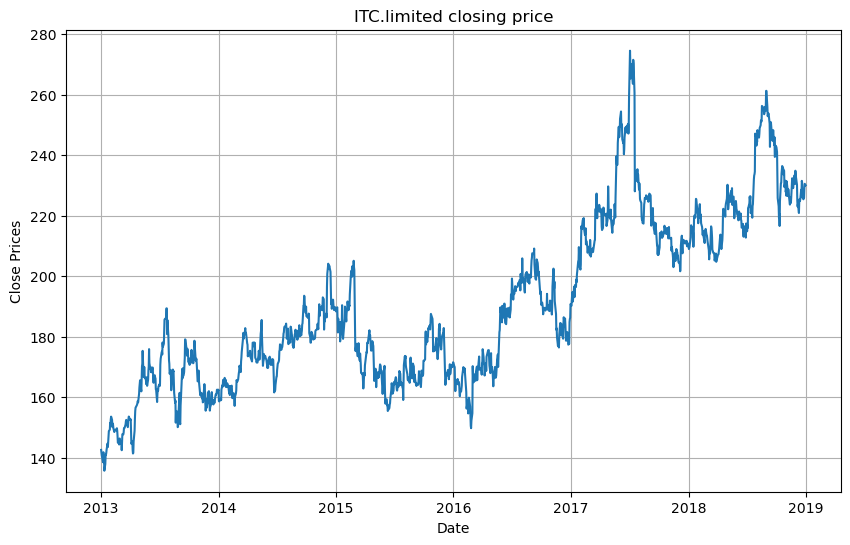

In [135]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('ITC.limited closing price')
plt.show()

# probability distribution to visualize the data in our series.

<Axes: ylabel='Density'>

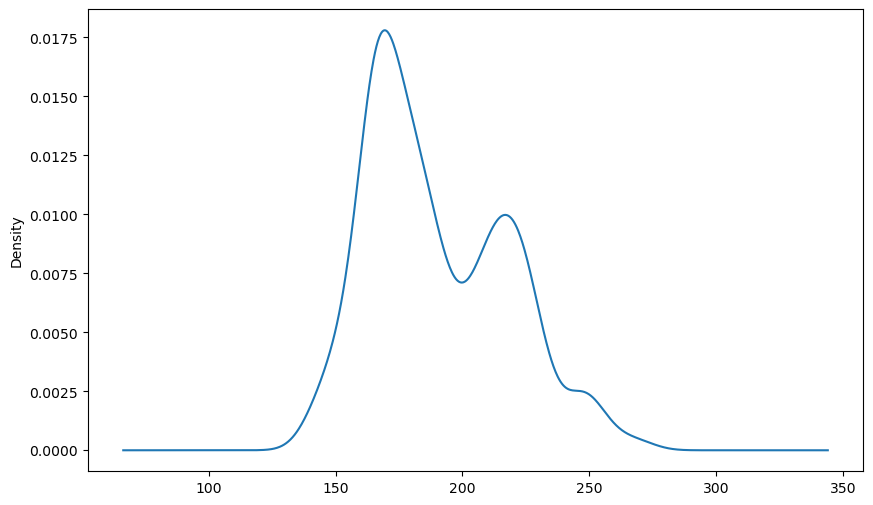

In [136]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')


# ADF (Augmented Dickey-Fuller) Test
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.
This test’s null and alternate hypotheses are:

* Null Hypothesis: The series has a unit root (value of a =1)

* Alternate Hypothesis: The series has no unit root.

If the null hypothesis is not rejected, the series is said to be non-stationary. The series can be linear or difference stationary as a result of this.

The series becomes stationary if both the mean and standard deviation are flat lines (constant mean and constant variance).

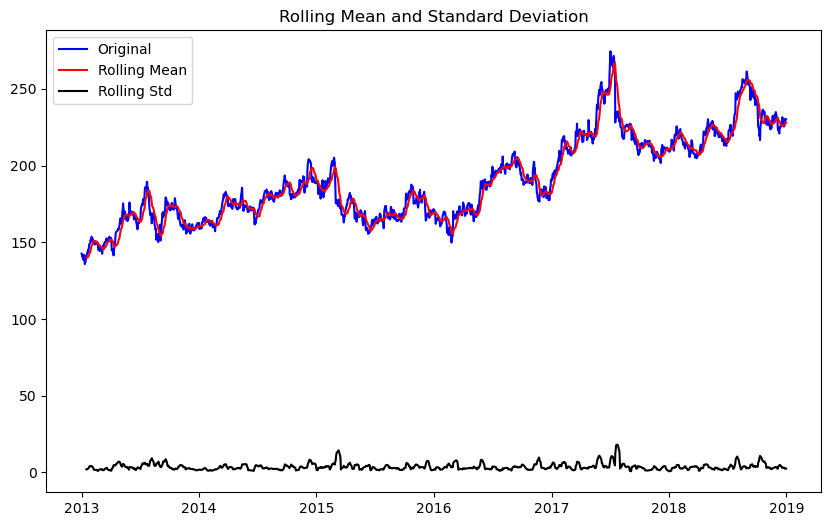

Results of dickey fuller test
Test Statistics                  -1.959915
p-value                           0.304421
No. of lags used                 11.000000
Number of observations used    1466.000000
critical value (1%)              -3.434818
critical value (5%)              -2.863514
critical value (10%)             -2.567821
dtype: float64


In [137]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

The increasing mean and standard deviation may be seen in the graph above, indicating that our series isn’t stationary.
We can’t rule out the Null hypothesis because the p-value is bigger than 0.05. Additionally, the test statistics exceed the critical values. As a result, the data is nonlinear.

Seasonality and trend may need to be separated from our series before we can undertake a time series analysis. This approach will cause the resulting series to become stagnant.

Let’s isolate the time series from the Trend and Seasonality.

<class 'pandas.core.series.Series'>


<Figure size 1000x600 with 0 Axes>

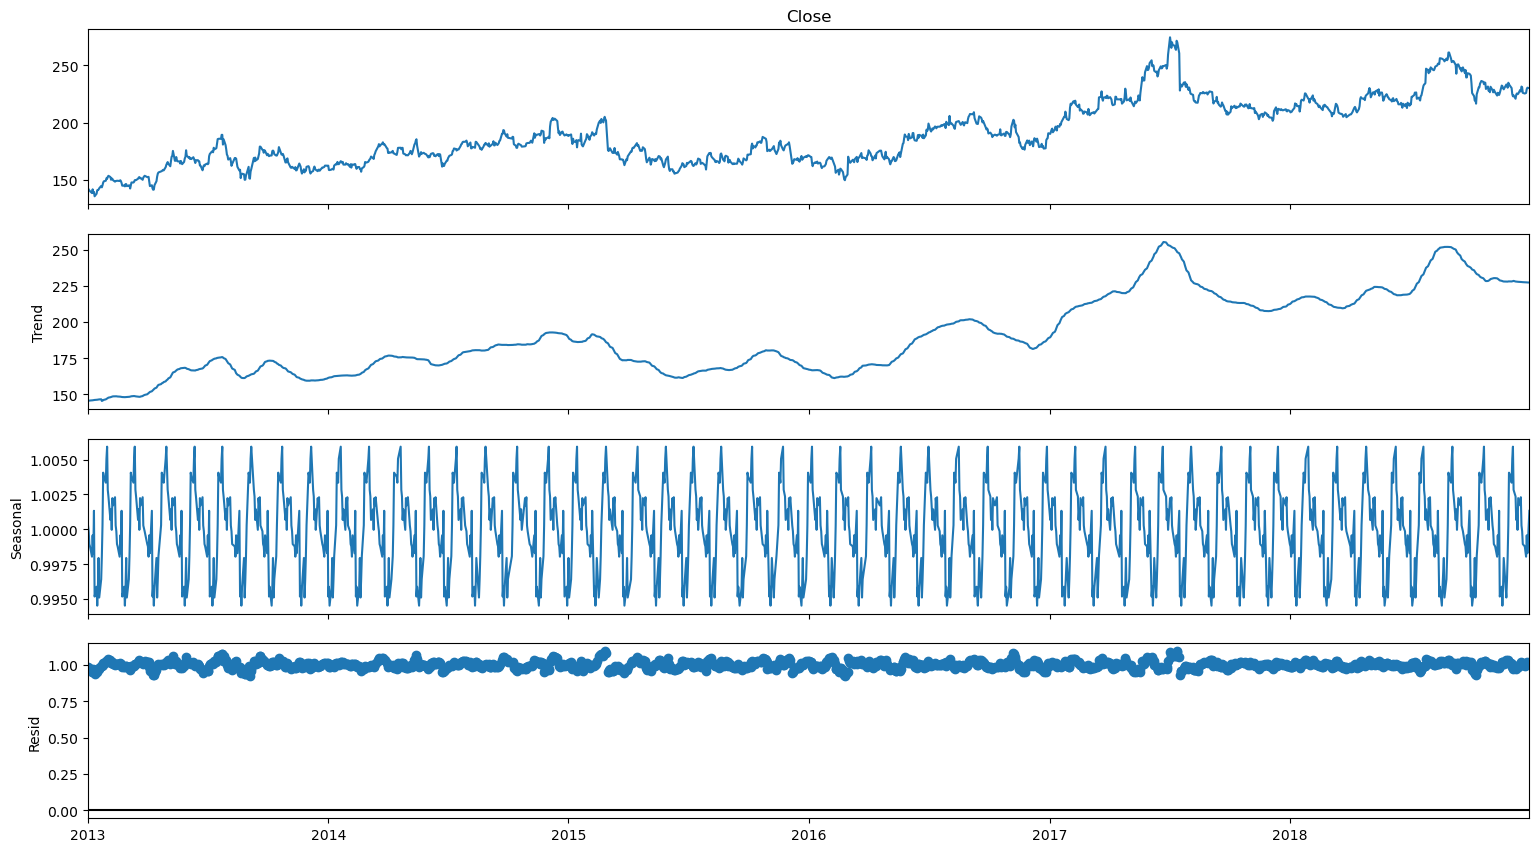

In [138]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
print(type(df_close))
result = seasonal_decompose(x = df_close, model='multiplicative',period=30, extrapolate_trend = 'freq')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)


To reduce the magnitude of the values and the growing trend in the series, we first take a log of the series. We then calculate the rolling average of the series after obtaining the log of the series. A rolling average is computed by taking data from the previous 12 months and calculating a mean consumption value at each subsequent point in the series.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


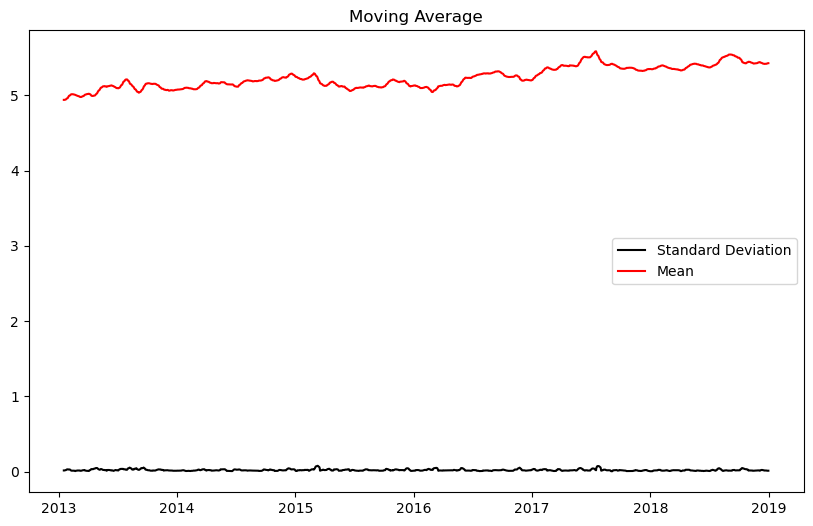

In [139]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now we’ll develop an ARIMA model and train it using the stock’s closing price from the train data. So, let’s visualize the data by dividing it into training and test sets.

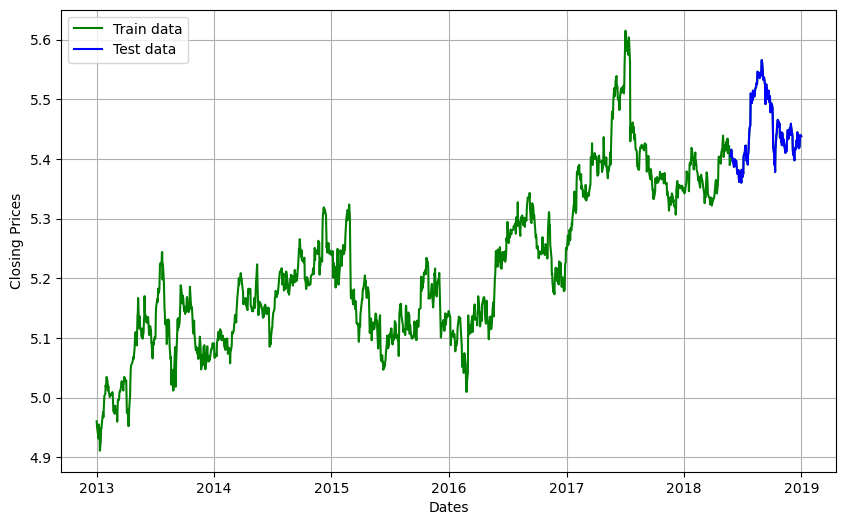

In [140]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
# print(len(train_data))
# print(len(test_data))
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

# Auto ARIMA: Automatically discover the optimal order for an ARIMA model.
The auro_arima function works by performing differencing tests

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8151.237, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-7207.104, Time=0.46 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-7206.786, Time=0.47 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-7215.095, Time=0.39 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-3277.215, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-7209.642, Time=1.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-7215.713, Time=0.25 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-4391.486, Time=0.38

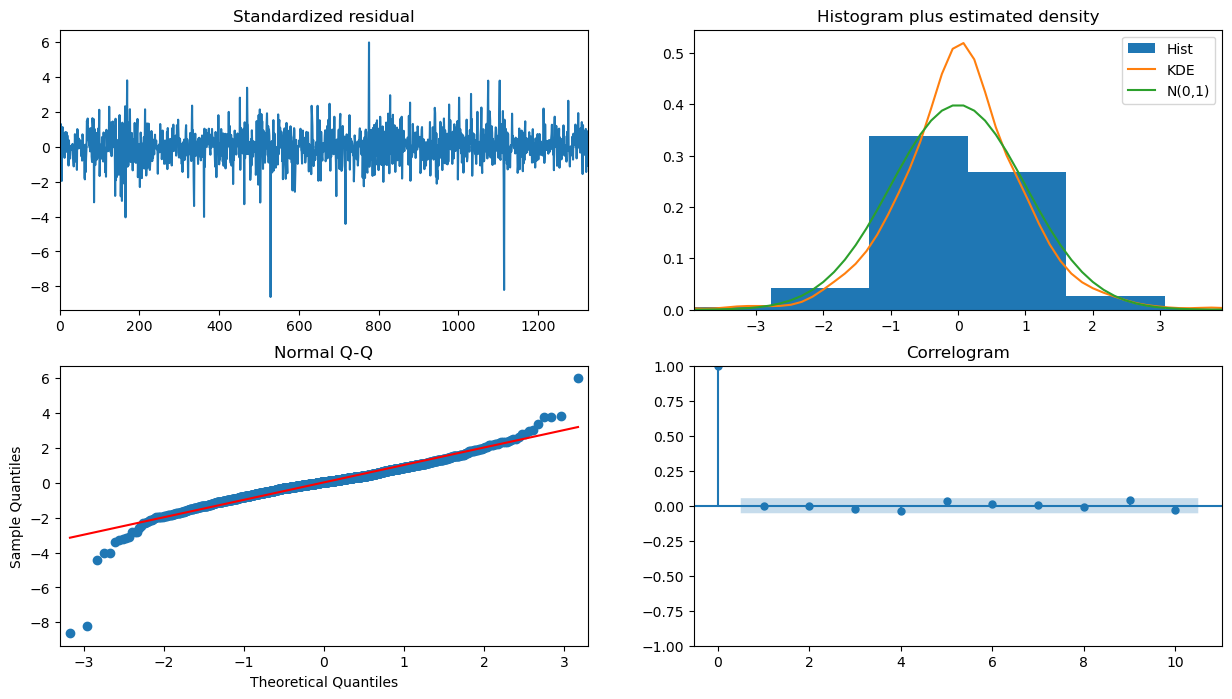

In [172]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

* Top left: The residual errors appear to have a uniform variance and fluctuate around a mean of zero. This is a good indication that the model has been trained correctly.

* Top Right: The density plot of the residual error values indicates that they are normally distributed with a mean of zero.

* Bottom left: All of the dots should fall perfectly in line with the red line. Any significant deviations would indicate that the distribution is skewed.

* Bottom Right: The residual errors are not autocorrelated, as shown by the Correlogram. Any autocorrelation would imply that the residual errors have a pattern that isn’t explained by the model. (as taught in class, the error variables should not be correlated with each other or with the independent variables.)

* We chose the values of p,d, and q as suggested by the auto_arima function. We then train the ARIMA model using the training data and make predictions on the test data.
* However, the autoarima dimension is working well for the first few observations only, so we will also use the ARIMA model with the values of p,d, and q that we have chosen with p = 1, d = 2, and q = 2. (trial and error gave this best fit)

In [173]:
from statsmodels.tsa.arima.model import ARIMA

In [174]:
#Modeling
# Build Model qith Auto ARIMA suggested parameters
model = ARIMA(train_data, order=(1,0,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1327
Model:                 ARIMA(1, 0, 2)   Log Likelihood                3612.983
Date:                Thu, 02 May 2024   AIC                          -7215.966
Time:                        14:29:15   BIC                          -7190.012
Sample:                             0   HQIC                         -7206.238
                               - 1327                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2138      0.040    129.397      0.000       5.135       5.293
ar.L1          0.9917      0.003    378.176      0.000       0.987       0.997
ma.L1          0.0038      0.025      0.154      0.8

# now begin forecasting stock prices on the test dataset with a 95% confidence level.

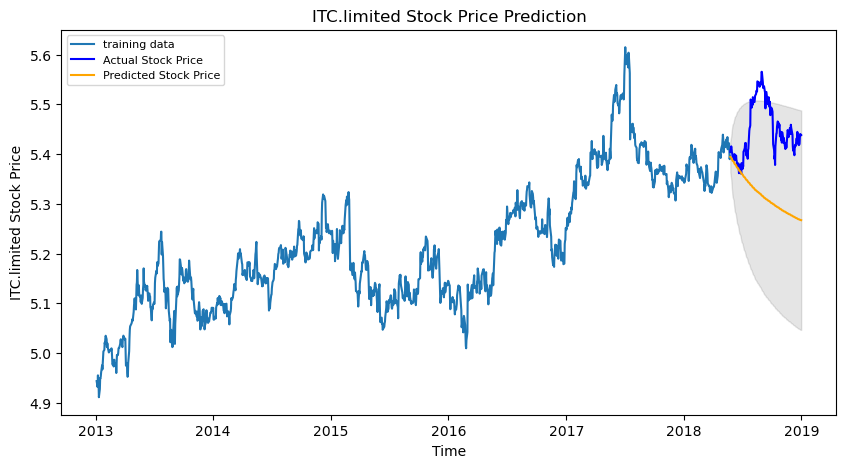

In [175]:
# Forecast
# print(type(fitted))
def forecast(fitted):

    forc = fitted.get_forecast(steps=148, signal_only=False, alpha=0.05)  # 95% conf
    forecast = pd.DataFrame(forc.summary_frame())
    forecast['date'] = test_data.index
    forecast = forecast.set_index('date')
    forecast = forecast.squeeze()
    # print(forecast.head())
    fc_series = pd.Series(forecast['mean'])
    lower_series = pd.Series(forecast['mean_ci_lower'], index=test_data.index)
    upper_series = pd.Series(forecast['mean_ci_upper'], index=test_data.index)
    # print("fc_series")
    # print(fc_series)
    # print("lower_series")
    # print(lower_series)
    # print("upper_series")
    # print(upper_series)


    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training data')
    plt.plot(test_data, color = 'blue', label='Actual Stock Price')
    plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                    color='k', alpha=.10)
    plt.title('ITC.limited Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('ITC.limited Stock Price')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

    return forecast

fc = forecast(fitted)
fc_series = pd.Series(fc['mean'])

common accuracy metrics for evaluating forecast results:

In [176]:
# report performance
def report_performance(test_data, fc_series):
    mse = mean_squared_error(test_data, fc_series)
    print('MSE: '+str(mse))
    mae = mean_absolute_error(test_data, fc_series)
    print('MAE: '+str(mae))
    rmse = math.sqrt(mean_squared_error(test_data, fc_series))
    print('RMSE: '+str(rmse))
    mape = np.mean(np.abs(fc_series - test_data)/np.abs(test_data))
    print('MAPE: '+str(mape))
    return mse, mae, rmse, mape

report_performance(test_data, fc_series)

MSE: 0.021754895080198
MAE: 0.12890746507037987
RMSE: 0.14749540698000735
MAPE: 0.023556852278752025


(0.021754895080198,
 0.12890746507037987,
 0.14749540698000735,
 0.023556852278752025)

With a MAPE of around 0.023, the model is 97.7% accurate in predicting the next 148 days of the stock price. It is more accurate in predicting the initial days of the stock price, as shown by the graph above.
This concludes that our arima model upon AUTO ARIMA is a good fit for the data, however, the model can be further improved.

# using our own ARIMA model with p=1, d=2, and q=2, we can predict the stock price for the next 148 days with a 95% confidence level.

In [177]:
# Build Model with trial error parameters (1,2,2) found to be the best
model = ARIMA(train_data, order=(1,2,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1327
Model:                 ARIMA(1, 2, 2)   Log Likelihood                3603.443
Date:                Thu, 02 May 2024   AIC                          -7198.886
Time:                        14:31:52   BIC                          -7178.129
Sample:                             0   HQIC                         -7191.105
                               - 1327                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9924      0.036    -27.762      0.000      -1.062      -0.922
ma.L1         -0.0091      0.579     -0.016      0.987      -1.145       1.126
ma.L2         -0.9909      0.565     -1.753      0.0

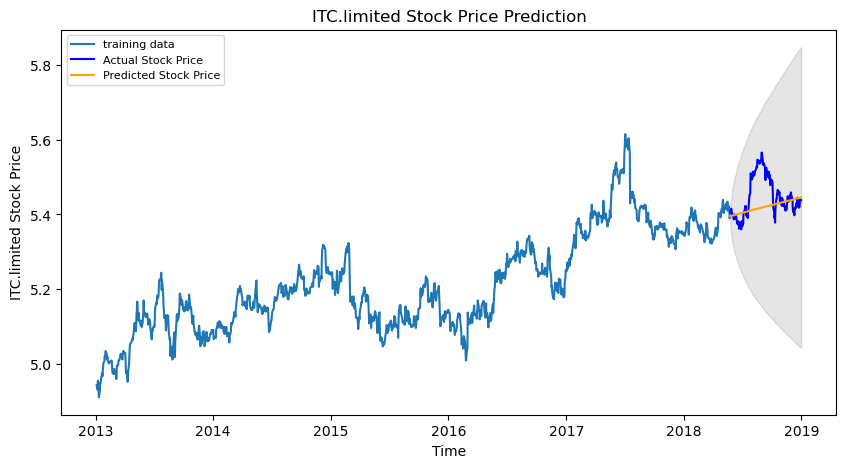

In [178]:
fc = forecast(fitted)
fc_series = pd.Series(fc['mean'])

In [179]:
report_performance(test_data, fc_series)

MSE: 0.0035042667937432593
MAE: 0.04214812590798752
RMSE: 0.05919684783620881
MAPE: 0.0076753449591386615


(0.0035042667937432593,
 0.04214812590798752,
 0.05919684783620881,
 0.0076753449591386615)

With a MAPE of around 0.0076, the model is 99.24% accurate in predicting the next 15 observations.
This concludes that our arima model upon self tuning is a good fit for the data.

# GARCH

In [ ]:
from arch import arch_model